In [ ]:
!git clone https://github.com/tezansahu/VQA-With-Multimodal-Transformers.git
!mkdir datasets
!mv VQA-With-Multimodal-Transformers/dataset/* ./datasets

In [ ]:
!pip install datasets==1.17.0 nltk==3.5 pandas==1.3.5 Pillow==9.0.0 scikit-learn==0.23.2
!pip install torch transformers==4.14.0
!pip install -U pillow

# 1) Multi Modal Transformers for VQA

https://medium.com/data-science-at-microsoft/visual-question-answering-with-multimodal-transformers-d4f57950c867

In [ ]:
import os
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
from PIL import Image
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel, TrainingArguments, Trainer, logging
from torch.utils.data import DataLoader, Dataset
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
from os import listdir

# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
dataset = load_dataset(
    "csv", 
    data_files={"train": "./datasets/data_train.csv", "test": "./datasets/data_eval.csv"}
)

with open("./datasets/answer_space.txt") as f:
    answer_space = f.read().splitlines()

# VQA task as a multiclass classification problem, need to create the labels from the actual answers
dataset = dataset.map(
    # Select the 1st answer if multiple answers are provided for single question
    lambda examples: {'label': [answer_space.index(ans.replace(" ", "").split(",")[0]) for ans in examples['answer']]},
    batched=True
)

print(answer_space)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

['1', '10', '11', '12', '13', '14', '15', '16', '18', '19', '2', '2163', '22', '3', '4', '5', '6', '7', '8', '9', 'air_conditioner', 'air_vent', 'alarm', 'alarm_clock', 'album', 'aluminium_foil', 'apple', 'ashtray', 'baby_chair', 'baby_gate', 'back_scrubber', 'backpack', 'bag', 'ball', 'balloon', 'banana', 'banister', 'bar_of_soap', 'basket', 'basketball', 'basketball_hoop', 'bathtub', 'bean_bag', 'bed', 'bed_sheets', 'belt', 'bench', 'bicycle', 'bicycle_helmet', 'bin', 'binder', 'black', 'blackboard', 'blanket', 'blender', 'blinds', 'blue', 'board', 'book', 'book_holder', 'bookrack', 'books', 'bookshelf', 'bottle', 'bottle_of_hand_wash_liquid', 'bottle_of_liquid', 'bottle_of_listerine', 'bottle_of_perfume', 'bottle_of_soap', 'bowl', 'box', 'box_of_paper', 'bread', 'brick', 'briefcase', 'broom', 'brown', 'bucket', 'bulb', 'bunk_bed', 'business_cards', 'cabinet', 'cable_box', 'cables', 'calculator', 'calendar', 'can', 'can_of_beer', 'candelabra', 'candle', 'candlestick', 'cane', 'canist

./datasets/images/image1168.png
Question:	 what is the colour of the blanket found
Answer:		 blue (Label: 56)


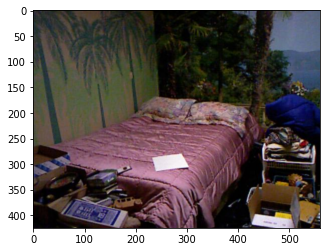

In [ ]:
def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    
    print(os.path.join(".", "datasets", "images", data[id]["image_id"] + ".png"))
    image = Image.open(os.path.join(".", "datasets", "images", data[id]["image_id"] + ".png"))
    imshow(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))
    
showExample()

In [ ]:
# processor
class MultimodalCollator:

    def __init__(self, tokenizer, preprocessor):
        self.tokenizer = tokenizer
        self.preprocessor = preprocessor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("datasets", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

# testing
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
preprocessor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
multimodal_collator = MultimodalCollator(tokenizer=tokenizer, preprocessor=preprocessor)

train_loader = DataLoader(dataset['train'], collate_fn=multimodal_collator, batch_size=5)
test_set = next(iter(train_loader))
for key in test_set.keys():
    print(key, test_set[key].size(), sep=' : ')

print("Labels: ", [answer_space[x] for x in test_set['labels']])

input_ids : torch.Size([5, 12])
token_type_ids : torch.Size([5, 12])
attention_mask : torch.Size([5, 12])
pixel_values : torch.Size([5, 3, 224, 224])
labels : torch.Size([5])
Labels:  ['cup', '6', 'curtain', '2', 'room_divider']


In [ ]:
# model structure
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,  
        pretrained_text_name="bert-base-uncased", 
        pretrained_image_name="google/vit-base-patch16-224-in21k", 
        num_labels=len(answer_space), 
        intermediate_dim=512, 
        dropout=0.5):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
	# Pretrained transformers for text & image featurization 
        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)
		
	# Fusion layer for cross-modal interaction
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
	# Fully-connected classifier
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        # [m, 12] --> [5, 768], [m, 12, 768]
        # pooler_output & last_hidden_state
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        # [m, 3, 224, 224] --> [5, 768], [5, 197, 768]
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )

        # [m, intermediate_dim]
        fused_output = self.fusion(
            torch.cat([encoded_text['pooler_output'], encoded_image['pooler_output']], dim=1)
        )

        # [m, class_size]
        logits = self.classifier(fused_output)
        out = {"logits": logits}

        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

# testing
model = MultimodalVQAModel()
result = model(**test_set)
print(len(answer_space))
print(result['logits'].size())

582
torch.Size([5, 582])


## 1.1 Loss Function

**Accuracy** and m**acro F1 score** are straightforward choices as metrics for evaluating the performance of our model. However, because these metrics may often be too restrictive, penalizing almost correct answers (‘tree’ versus ‘plant’) as heavily as incorrect answers (‘tree’ versus ‘table’), we select a metric like WUPS as our primary evaluation metric. Such a metric considers the semantic similarity between the predicted answer and the ground truth.

One option to evaluate open-ended natural language answers is to perform exact string matching. However, it is too stringent and cannot capture the semantic relatedness between the predicted answer and the ground truth. This prompts the use of other metrics that capture the semantic similarity of strings effectively. One such commonly used metric is the Wu and Palmer Similarity (WUPS) Score.

WUPS computes the semantic similarity between two words or phrases based on their longest common subsequence in the taxonomy tree. This score works well for single-word answers (hence, we use it for our task), but may not work for phrases or sentences.

Nltk has an implementation of the WUPS based on the WordNet taxonomy.

In [ ]:
import sys
from numpy import prod
from nltk.corpus import wordnet as wn

def wup_measure(a, b, similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wn.synsets(a,pos=wn.NOUN)
        return (semantic_field,weight)

    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)

    global_weight=1.0
    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0

    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

# Wrapper around the wup_measure(...) function to process batch inputs
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

# Function to compute all relevant performance metrics, to be passed into the trainer
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }